Prepare Google Colab notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install and Import Required Dependencies

In [2]:
!pip install tensorflow
!pip install tensorflow-hub
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.0 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Define Constants

In [4]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 10

Data Preprocessing

Split into training and validation sets (80/20)

In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2,  # 20% for validation
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

In [6]:
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/CSC3009Project/dataset_13',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 384 images belonging to 4 classes.


In [7]:
validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/CSC3009Project/dataset_13',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 96 images belonging to 4 classes.


Load EfficientNetB0 with pre-trained weights and without the top

In [8]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

16705208/16705208 [==============================] - 1s 0us/step


Add custom classification layers

In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

Define the model

In [10]:
model = Model(inputs=base_model.input, outputs=outputs)

Compile the model

In [11]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

Train the model

In [12]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping],
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.7123 - accuracy: 0.7031

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 197s 13s/step - loss: 0.7123 - accuracy: 0.7031 - val_loss: 1.9197 - val_accuracy: 0.5312
Epoch 2/10
12/12 [==============================] - 10s 848ms/step - loss: 0.2446 - accuracy: 0.9193 - val_loss: 1.4874 - val_accuracy: 0.6979
Epoch 3/10
12/12 [==============================] - 8s 643ms/step - loss: 0.2099 - accuracy: 0.9193 - val_loss: 1.9121 - val_accuracy: 0.6562
Epoch 4/10
12/12 [==============================] - 9s 796ms/step - loss: 0.0889 - accuracy: 0.9661 - val_loss: 1.5596 - val_accuracy: 0.8021
Epoch 5/10
12/12 [==============================] - 10s 802ms/step - loss: 0.0822 - accuracy: 0.9740 - val_loss: 1.4267 - val_accuracy: 0.7917
Epoch 6/10
12/12 [==============================] - 9s 710ms/step - loss: 0.0746 - accuracy: 0.9740 - val_loss: 1.1732 - val_accuracy: 0.8229
Epoch 7/10
12/12 [==============================] - 10s 802ms/step - loss: 0.0635 - accuracy: 0.9740 - val_loss: 1.5033 - val_accuracy: 0.7083
Epoch 8/10
12/

Unfreeze some layers and fine-tune the model

In [13]:
for layer in base_model.layers:
    layer.trainable = True

Re-compile the model with a lower learning rate

In [14]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

Fine-tune the model

In [15]:
history_fine = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping],
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

Epoch 1/10
12/12 [==============================] - 43s 970ms/step - loss: 0.0135 - accuracy: 0.9974 - val_loss: 0.7744 - val_accuracy: 0.8542
Epoch 2/10
12/12 [==============================] - 10s 801ms/step - loss: 0.0394 - accuracy: 0.9844 - val_loss: 0.8087 - val_accuracy: 0.8854
Epoch 3/10
12/12 [==============================] - 9s 752ms/step - loss: 0.0191 - accuracy: 0.9896 - val_loss: 0.6715 - val_accuracy: 0.8958
Epoch 4/10
12/12 [==============================] - 11s 928ms/step - loss: 0.0295 - accuracy: 0.9948 - val_loss: 0.7502 - val_accuracy: 0.8646
Epoch 5/10
12/12 [==============================] - 10s 857ms/step - loss: 0.0099 - accuracy: 0.9974 - val_loss: 0.5016 - val_accuracy: 0.8958
Epoch 6/10
12/12 [==============================] - 8s 656ms/step - loss: 0.0254 - accuracy: 0.9948 - val_loss: 0.5618 - val_accuracy: 0.8750
Epoch 7/10
12/12 [==============================] - 10s 812ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.5111 - val_accuracy: 0.8750
E

Save the model

In [16]:
model.save('efficientnet_b0_brain_mri.h5')

Make predictions on the validation data

In [17]:
val_predicted_classes = np.argmax(model.predict(validation_generator), axis=-1)

3/3 [==============================] - 3s 674ms/step


Get true labels and compute confusion matrix

In [18]:
val_true_classes = validation_generator.classes
val_class_labels = list(validation_generator.class_indices.keys())
val_conf_matrix = confusion_matrix(val_true_classes, val_predicted_classes)

Plot the confusion matrix and print classification report

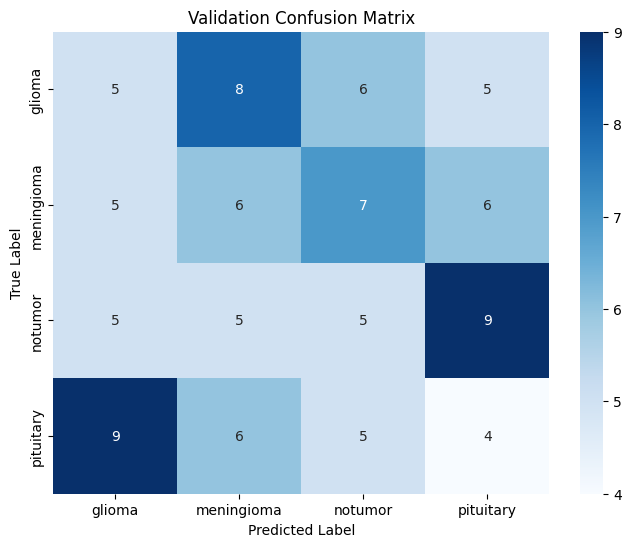

              precision    recall  f1-score   support

      glioma       0.21      0.21      0.21        24
  meningioma       0.24      0.25      0.24        24
     notumor       0.22      0.21      0.21        24
   pituitary       0.17      0.17      0.17        24

    accuracy                           0.21        96
   macro avg       0.21      0.21      0.21        96
weighted avg       0.21      0.21      0.21        96



In [19]:
plt.figure(figsize=(8, 6))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_class_labels, yticklabels=val_class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Validation Confusion Matrix')
plt.show()

print(classification_report(val_true_classes, val_predicted_classes, target_names=val_class_labels))

Load and preprocess the validation data (Get class labels, select a single image and its label)

In [20]:
x_batch, y_batch = next(validation_generator)  # Get a batch of images and labels
image = x_batch[0]  # Select the first image in the batch
true_label = np.argmax(y_batch[0])  # Get the true label index

Predict the class of the selected image

In [21]:
image_expanded = np.expand_dims(image, axis=0)  # Expand dimensions to match input shape
predictions = model.predict(image_expanded)
predicted_label = np.argmax(predictions[0])

1/1 [==============================] - 3s 3s/step


Plot the image and print true and predicted labels

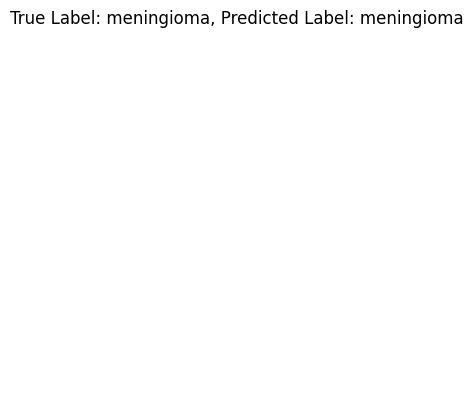

True Label: meningioma
Predicted Label: meningioma


In [23]:
plt.imshow(image / 2 + 0.5)  # Undo preprocessing for display (if necessary)
plt.title(f'True Label: {val_class_labels[true_label]}, Predicted Label: {val_class_labels[predicted_label]}')
plt.axis('off')
plt.show()

print(f'True Label: {val_class_labels[true_label]}')
print(f'Predicted Label: {val_class_labels[predicted_label]}')